In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import squidpy as sq

In [2]:
CNTPTH_1 = "/home/alma/w-projects/ccf/data/bc/bc1/"
CNTPTH_2 = "/home/alma/w-projects/ccf/data/bc/bc2"

In [3]:
adata_1 = sc.read_visium(CNTPTH_1)
adata_2 = sc.read_visium(CNTPTH_2)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


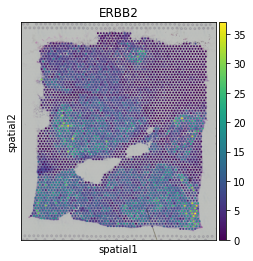

... storing 'feature_types' as categorical
... storing 'genome' as categorical


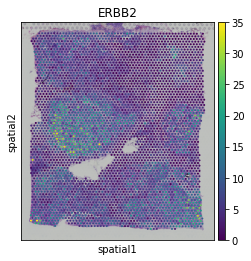

In [4]:
sc.pl.spatial(adata_1,color ="ERBB2")
sc.pl.spatial(adata_2,color ="ERBB2")

In [5]:
for adata in [adata_1,adata_2]:
    sc.pp.normalize_per_cell(adata,1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata,n_neighbors=15)
    sc.tl.umap(adata)
    sq.gr.spatial_neighbors(adata,
                            n_neigh=6,
                            coord_type="visium",
                            )

/home/alma/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/alma/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/alma/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call 

In [533]:
for adata in [adata_1,adata_2]:


In [425]:
def generate_landmark_profiles(adata: ad.AnnData,
                               neighbor_fraction_threshold = 0.5,
                               n_spatial_neighbors = 6,
                               **kwargs,
                              ):
    
    if "neighbors_key" in kwargs:
        if "distances" not in adata.obsp[kwargs["neighbors_key"]]:
            if "neighbors" not in adata.uns:
                sc.pp.neighbors(adata,
                                n_neighbors=kwargs.get("embedding_neighbors",4),
                                neighbors_key=kwargs["neighbors_key"],
                               )
            sc.tl.umap(adata,neighbors_key=kwargs["neighbors_key"])
            
        em_gr = adata.obsp[kwargs["neighbors_key"]]["distances"]
        em_conn = adata.obsp[kwargs["neighbors_key"]]["connectivities"]
    else:
        if "distances" not in adata.obsp:
            if neighbors not in adata.obsp:
                sc.pp.neighbors(adata,
                               n_neighbors=n_spatial_neighbors,
                               )
                               
            sc.tl.umap(adata)
            
        em_gr = adata.obsp["distances"]
        em_conn = adata.obsp["connectivities"]
        
    sp_gr = adata.obsp["spatial_connectivities"]

    landmarks = []
    expression = []
    
    for ii in range(adata.shape[0]):
        em_ptr = slice(em_gr.indptr[ii],em_gr.indptr[ii+1])
        sp_ptr = slice(sp_gr.indptr[ii],sp_gr.indptr[ii+1])
        em_ind = em_gr.indices[em_ptr]
        sp_ind = sp_gr.indices[sp_ptr]

        em_ind = set(em_ind)
        sp_ind = set(sp_ind)
        em_n_sp = list(em_ind.intersection(sp_ind))
        
        neighbor_fraction = len(em_n_sp) / n_spatial_neighbors
            
        if neighbor_fraction >= neighbor_fraction_threshold:
            sp_crd = adata.obsm["spatial"][em_n_sp] 
            ws = em_conn.data[em_n_sp]
            ws = ws/ ws.sum()
            ws = ws[:,np.newaxis]
            sp_crd = (sp_crd * ws).sum(axis=0)
            landmarks.append(sp_crd)
            expr = (np.array(adata.X[em_n_sp,:].todense()) * ws).sum(axis=0)
            expression.append(expr)
            
    landmarks = np.array(landmarks)
    expression = np.array(expression)
    
    res = dict(spatial = landmarks,
               expression = expression,
              )
    
    adata.uns["raw_landmarks"] = res

In [534]:
generate_landmark_profiles(adata_1,neighbor_fraction_threshold=0.5)
generate_landmark_profiles(adata_2,neighbor_fraction_threshold=0.5)

In [535]:
landmarks = adata_1.uns["raw_landmarks"]["spatial"]
expession = adata_1.uns["raw_landmarks"]["expression"]

(3369.15, 21119.85, 3142.45, 23020.55)

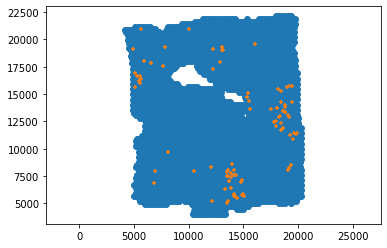

In [536]:
crd = adata_1.obsm["spatial"]
plt.scatter(crd[:,0],crd[:,1])
plt.scatter(landmarks[:,0],landmarks[:,1],s = 10,marker = "+")
plt.axis("equal")

In [537]:
from typing import Dict, List

In [519]:
help(list.sort)

Help on method_descriptor:

sort(self, /, *, key=None, reverse=False)
    Stable sort *IN PLACE*.



In [543]:
def match_landmarks(adatas : List[ad.AnnData],
                    max_landmarks:int = 10,
                    n_box_x: int = 3,
                    n_box_y: int = 3,
                    n_boxpoints: int = 2,
                    n_iter = 1,
                   ):
    
    assert all(["raw_landmarks" in a.uns for a in adatas]),\
    "needs to have raw landmarks added"
    n_samples = len(adatas)
    ref_adata = adatas[0]
    ref_expr = ref_adata.uns["raw_landmarks"]["expression"].copy()
    
    n_landmarks = [a.uns["raw_landmarks"]["spatial"].shape[0] for \
                      a in adatas]
    min_landmarks = min(min(n_landmarks),max_landmarks)
    order = np.argsort(n_landmarks)
    adatas = [adatas[x] for x in order]
    
    new_ref_expr = np.zeros((min_landmarks,ref_expr.shape[1]))
    
    for it in range(n_iter):
        for k in range(1,n_samples):
                que_adata = adatas[k]
                que_expr = que_adata.uns["raw_landmarks"]["expression"]
                if k == 1:
                    dmat = cdist(ref_expr,que_expr,metric = "cosine")
                else:
                    dmat = cdist(new_ref_expr,que_expr,metric = "cosine")

                pairs = np.zeros((min_landmarks,2),dtype = np.int)
                for p in range(min_landmarks):
                    row,col = np.unravel_index(np.argmin(dmat),
                                               dmat.shape)
                    dmat[row,:] = np.inf
                    dmat[:,col] = np.inf
                    pairs[p,:] = (row,col)

                if k == 1 and it == 0:
                    new_ref_expr = (ref_expr[pairs[:,0],:] + \
                                    que_expr[pairs[:,1],:]) / 2
                else:
                    new_ref_expr[pairs[:,0],:] = new_ref_expr[pairs[:,0],:] * \
                    (k-1) / k  + que_expr[pairs[:,1],:] /k 

    for k in range(n_samples):
        que_adata = adatas[k]
        que_expr = que_adata.uns["raw_landmarks"]["expression"]
        que_landmark = que_adata.uns["raw_landmarks"]["spatial"]
        dmat = cdist(new_ref_expr,que_expr,metric = "cosine")
        landmark_id = np.zeros(min_landmarks,dtype = np.int)
        
        for row in range(min_landmarks):
            col = np.argmin(dmat[row,:])
            dmat[row,:] = np.inf
            dmat[:,col] = np.inf
            landmark_id[row] = col
            
        que_adata.uns["matched_landmarks"] = dict(expression = que_expr[landmark_id,:],
                                                  spatial = que_landmark[landmark_id,:]
                                                 )
                

In [524]:
adata_1

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'spatial_neighbors', 'raw_landmarks', 'matched_landmarks'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities'

In [574]:
match_landmarks([adata_1,adata_2],max_landmarks=20,n_iter=1)

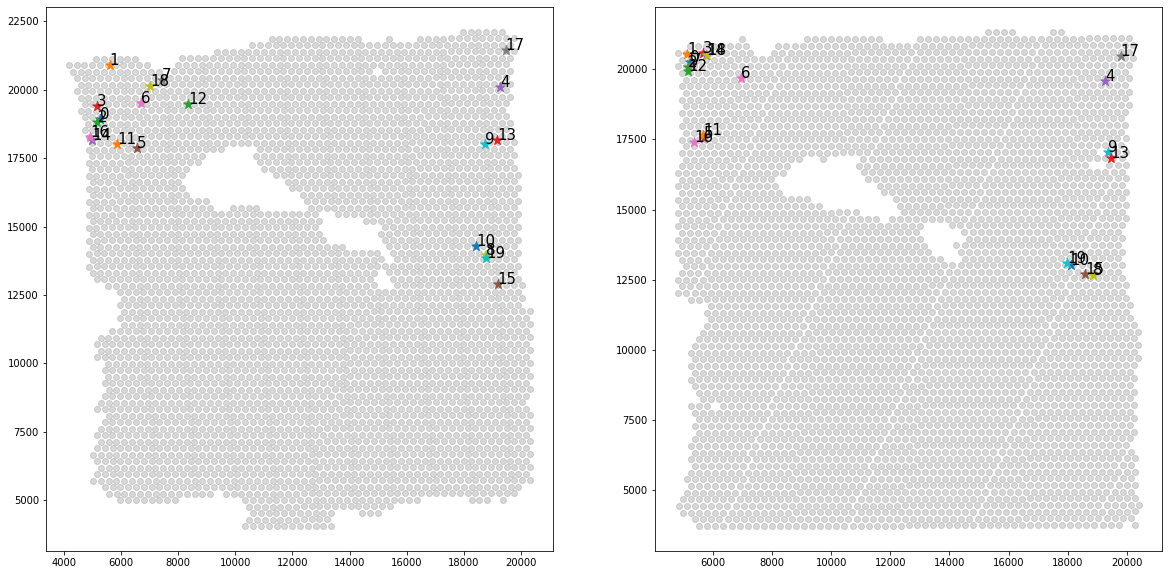

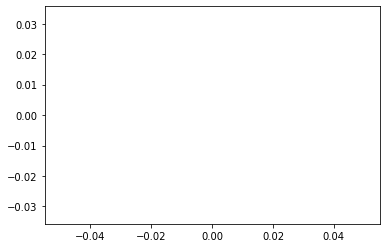

In [575]:
fig,ax = plt.subplots(1,2,figsize = (20,10))
ax1,ax2 = ax
crd_1 = adata_1.obsm["spatial"]
crd_2 = adata_2.obsm["spatial"]
ax1.scatter(crd_1[:,0],crd_1[:,1], c = "gray",alpha = 0.3)
ax2.scatter(crd_2[:,0],crd_2[:,1], c = "gray", alpha = 0.3)
n_lanmdarks = adata_1.uns["matched_landmarks"]["spatial"].shape[0]

lmrk_1 = adata_1.uns["matched_landmarks"]["spatial"]
lmrk_2 = adata_2.uns["matched_landmarks"]["spatial"]

for ii in range(n_lanmdarks):
    ax1.scatter(lmrk_1[ii,0],lmrk_1[ii,1],marker = "*",s=100)
    ax1.text(lmrk_1[ii,0],lmrk_1[ii,1],s = str(ii),fontsize=15)
#    ax1.scatter(X,Y)
    ax2.scatter(lmrk_2[ii,0],lmrk_2[ii,1],marker = "*",s=100)
    ax2.text(lmrk_2[ii,0],lmrk_2[ii,1],s = str(ii),fontsize=15)


plt.show()
#plt.scatter(landmarks[:,0],landmarks[:,1],s = 10,marker = "+")
plt.axis("equal")
plt.show()

(-0.5, 36600.5, 9.5, -0.5)

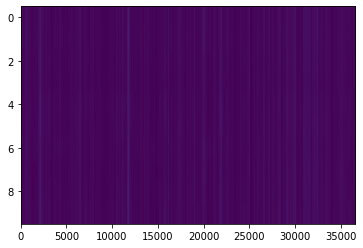

In [510]:
plt.imshow(ref)
plt.axis("auto")

In [469]:
    
    xx = np.linspace(crd_1[:,0].min(),crd_1[:,0].max(),n_box_x + 1)
    yy = np.linspace(crd_1[:,1].min(),crd_1[:,1].max(),n_box_y + 1)
    
    for ii in range(n_box_x):
        in_box_x = (xx_1[ii] < ref_landmarks[:,0]) &\
                (ref_landmarks[:,0] < xx_1[ii+1])
    for jj in range(n_box_y):
        in_box_y = (yy_1[jj] < ref_landmarks[:,1]) &\
                   (ref_landmarks[:,1] < yy_1[jj+1])

        in_box = np.where((in_box_x) & (in_box_y))[0]
        n_in_box = sum(in_box)
        n_points = min(n_in_box,n_boxpoints)
        
        

NameError: name 'k' is not defined

IndexError: index 13 is out of bounds for axis 0 with size 10

In [372]:
n_boxes = 3
n_points = 2
xx_1 = np.linspace(crd_1[:,0].min(),crd_1[:,0].max(),n_boxes + 1)
yy_1 = np.linspace(crd_1[:,1].min(),crd_1[:,1].max(),n_boxes + 1)
landmark_pairs = []


for ii in range(n_boxes):
    in_box_x = (xx_1[ii] < landmarks_1[:,0]) & (landmarks_1[:,0] < xx_1[ii+1])
    for jj in range(n_boxes):
        in_box_y = (yy_1[jj] < landmarks_1[:,1]) & (landmarks_1[:,1] < yy_1[jj+1])
        in_box = np.where((in_box_x) & (in_box_y))[0]
        n_in_box = sum(in_box)
        if n_in_box > 0:
            sub_dmat  = dmat[in_box,:]
            for p in range(n_points):
                row,col = np.unravel_index(np.argmin(sub_dmat),sub_dmat.shape)
                sub_dmat[row,:] = np.inf
                sub_dmat[:,col] = np.inf
                row = in_box[row]
                landmark_pairs.append([row,col])


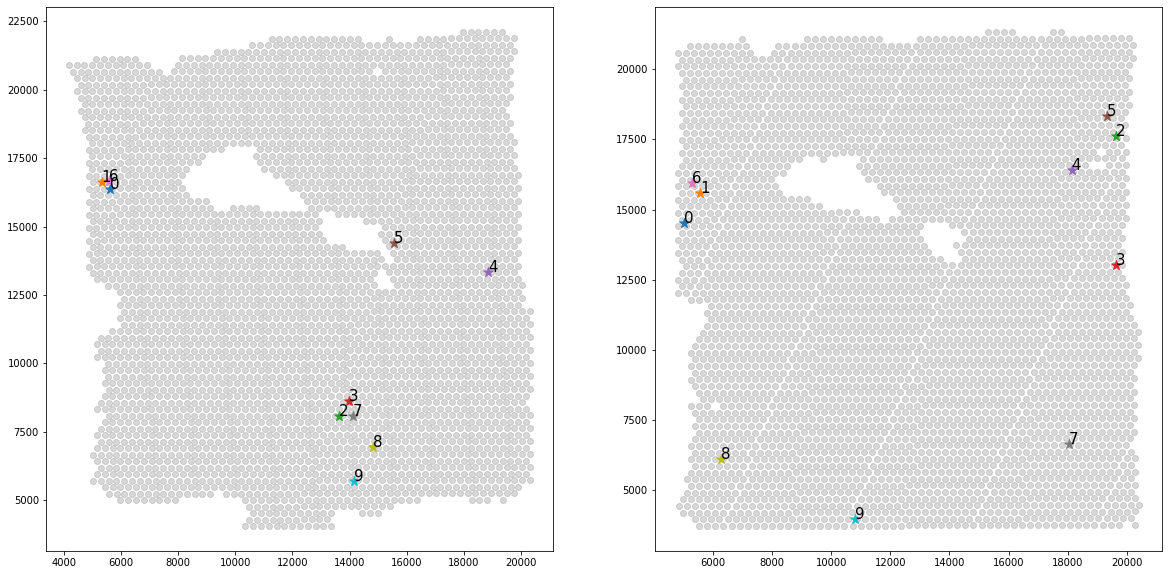

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

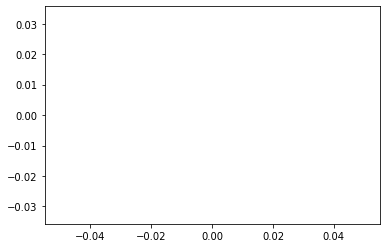

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    

import preprocess as pp

In [553]:
adata_1 = sc.read_visium(CNTPTH_1)
adata_2 = sc.read_visium(CNTPTH_2)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [700]:
adata_1.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["scalefactors"]

{'spot_diameter_fullres': 177.48170171293427,
 'tissue_hires_scalef': 0.08250825,
 'fiducial_diameter_fullres': 286.70121045935537,
 'tissue_lowres_scalef': 0.024752475}

In [554]:
for adata in [adata_1,adata_2]:
    sc.pp.normalize_per_cell(adata,1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata,n_neighbors=15)
    sc.tl.umap(adata)
    sq.gr.spatial_neighbors(adata,
                            n_neigh=6,
                            coord_type="visium",
                            )

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
for adata in [adata_1,adata_2]:
    pp.find_landmark_candidates(adata)
    print(adata)

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'spatial_neighbors', 'raw_landmarks'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities'
AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'spatial_neighbors', 'raw_landmarks'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities'


In [9]:
pp.match_landmarks([adata_1,adata_2],max_landmarks=20)

[[0.         0.         0.         ... 0.         0.19909939 0.        ]
 [0.         0.         0.         ... 0.         0.4821021  0.        ]
 [0.         0.         0.         ... 0.         0.14620185 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.04348079 0.        ]
 [0.         0.         0.         ... 0.         0.1782438  0.        ]]


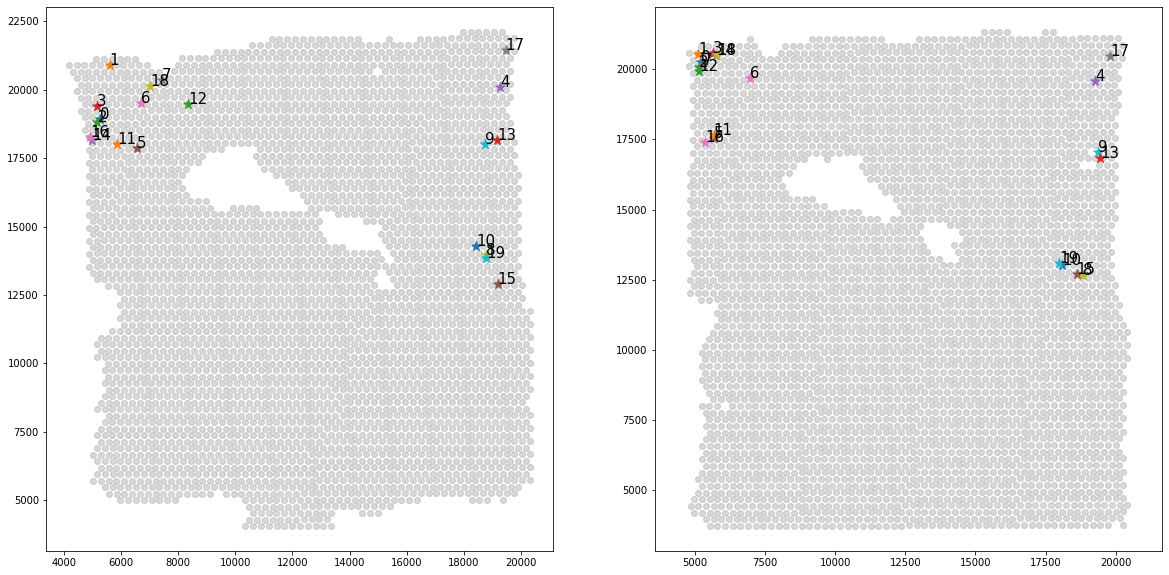

In [10]:
fig,ax = plt.subplots(1,2,figsize = (20,10))
ax1,ax2 = ax
crd_1 = adata_1.obsm["spatial"]
crd_2 = adata_2.obsm["spatial"]
ax1.scatter(crd_1[:,0],crd_1[:,1], c = "gray",alpha = 0.3)
ax2.scatter(crd_2[:,0],crd_2[:,1], c = "gray", alpha = 0.3)
n_landmarks = adata_1.uns["curated_landmarks"].shape[0]

lmrk_1 = adata_1.uns["curated_landmarks"]
lmrk_2 = adata_2.uns["curated_landmarks"]

for ii in range(n_landmarks):
    ax1.scatter(lmrk_1[ii,0],lmrk_1[ii,1],marker = "*",s=100)
    ax1.text(lmrk_1[ii,0],lmrk_1[ii,1],s = str(ii),fontsize=15)
#    ax1.scatter(X,Y)
    ax2.scatter(lmrk_2[ii,0],lmrk_2[ii,1],marker = "*",s=100)
    ax2.text(lmrk_2[ii,0],lmrk_2[ii,1],s = str(ii),fontsize=15)

plt.axis("equal")
plt.show()
#plt.scatter(landmarks[:,0],landmarks[:,1],s = 10,marker = "+")


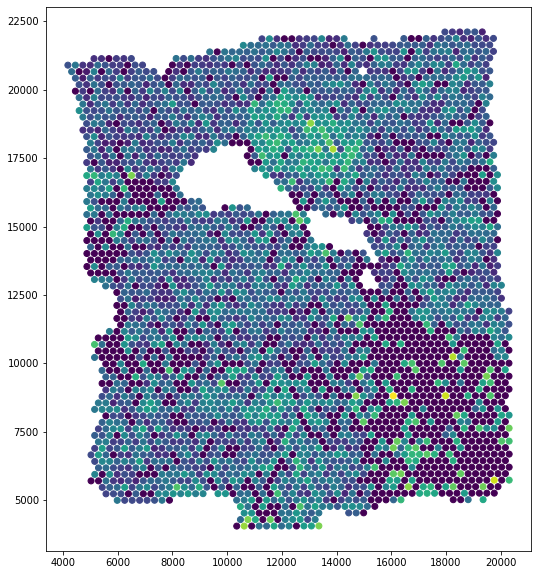

In [28]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(crd_1[:,0],crd_1[:,1], c = adata_1.obs_vector("CD47"))
ax.set_aspect("equal")


In [29]:
import os
import os.path as osp
MOB_DIR = "/home/alma/w-projects/ccf/data/mb-sag/"
adatas = [sc.read_visium(osp.join(MOB_DIR,a)) for a in ["s1","s2"]]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [30]:
for adata in adatas:
    sc.pp.normalize_per_cell(adata,1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata,n_neighbors=15)
    sc.tl.umap(adata)
    sq.gr.spatial_neighbors(adata,
                            n_neigh=6,
                            coord_type="visium",
                            )

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [31]:
for adata in adatas:
    pp.find_landmark_candidates(adata,neighbor_fraction_threshold=0.5)
    print(adata.uns["raw_landmarks"]["spatial"])

[[2804.77090449 8502.44707103]
 [4276.47625454 7603.04621227]
 [2332.40496088 9062.92639115]
 ...
 [4676.14066583 7128.13393621]
 [3705.73578657 6977.0372314 ]
 [4320.54929933 8373.95027223]]
[[ 4455.01638809 10257.97795966]
 [ 2368.25736666  9220.97181812]
 [ 3065.6146742   9431.29422285]
 ...
 [ 3098.73427913  7879.96534896]
 [ 4436.84648722  8568.54639464]
 [ 3665.3747009   8758.7374588 ]]


In [32]:
pp.match_landmarks(adatas,max_landmarks=20)

[[0.         0.         0.         ... 0.         0.         0.9763997 ]
 [0.         0.         0.         ... 0.         0.         1.0387131 ]
 [0.         0.         0.01392342 ... 0.         0.         1.0432305 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.44399765]
 [0.         0.         0.         ... 0.         0.         0.8072066 ]
 [0.         0.         0.01061953 ... 0.         0.         1.064937  ]]


In [ ]:
sc.pl.sp

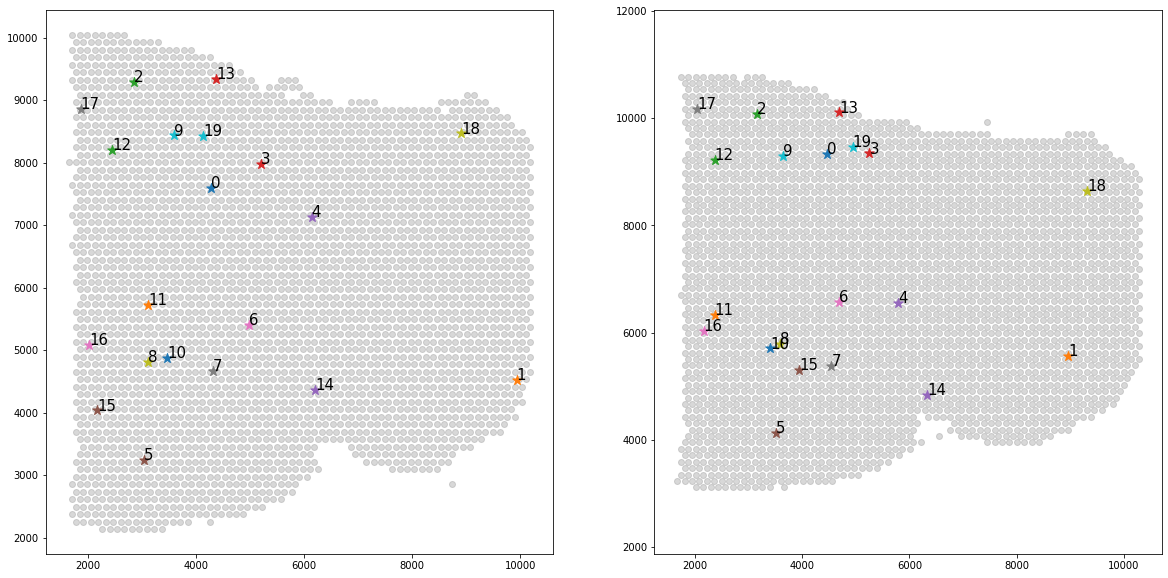

In [33]:
fig,ax = plt.subplots(1,2,figsize = (20,10))
ax1,ax2 = ax
crd_1 = adatas[0].obsm["spatial"]
crd_2 = adatas[1].obsm["spatial"]
ax1.scatter(crd_1[:,0],crd_1[:,1], c = "gray",alpha = 0.3)
ax2.scatter(crd_2[:,0],crd_2[:,1], c = "gray", alpha = 0.3)
n_landmarks = adatas[0].uns["curated_landmarks"].shape[0]

lmrk_1 = adatas[0].uns["curated_landmarks"]
lmrk_2 = adatas[1].uns["curated_landmarks"]

for ii in range(n_landmarks):
    ax1.scatter(lmrk_1[ii,0],lmrk_1[ii,1],marker = "*",s=100)
    ax1.text(lmrk_1[ii,0],lmrk_1[ii,1],s = str(ii),fontsize=15)
#    ax1.scatter(X,Y)
    ax2.scatter(lmrk_2[ii,0],lmrk_2[ii,1],marker = "*",s=100)
    ax2.text(lmrk_2[ii,0],lmrk_2[ii,1],s = str(ii),fontsize=15)

plt.axis("equal")
plt.show()
#plt.scatter(landmarks[:,0],landmarks[:,1],s = 10,marker = "+")


In [39]:
adata_1.obs_vector("VIM").shape

(3798,)

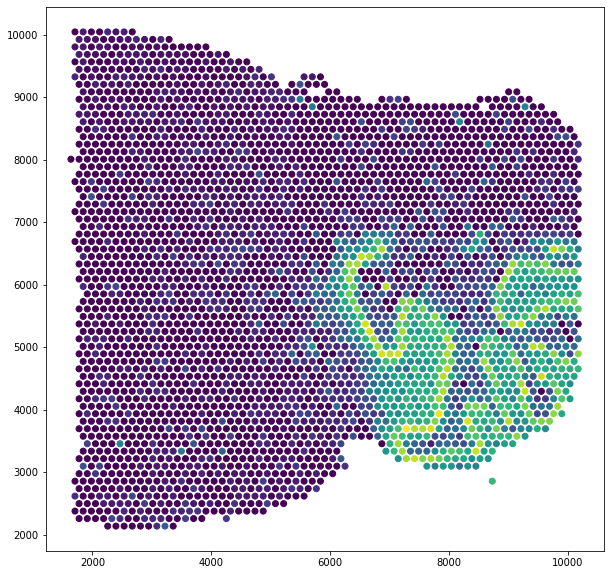

In [48]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(crd_1[:,0],crd_1[:,1], c = adatas[0].obs_vector("Car8"))

In [52]:
adata.uns["raw_landmarks"]["spatial"]

array([[2804.77090449, 8502.44707103],
       [4276.47625454, 7603.04621227],
       [2332.40496088, 9062.92639115],
       ...,
       [4676.14066583, 7128.13393621],
       [3705.73578657, 6977.0372314 ],
       [4320.54929933, 8373.95027223]])

In [53]:
for adata in adatas:
    pp.get_landmark_distance(adata)

In [59]:
import models as m
import methods as f

ref = m.Reference(crd_1,
                  landmarks = adatas[0].uns["curated_landmarks"],
                 )

models = f.map_to_reference(adatas[1],
                           "Car8",
                            ref,
                            n_epochs=10000,
                           )

/home/alma/w-projects/ccf/src/models.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.landmarks = t.tensor(landmarks)


KeyboardInterrupt: 

In [57]:
ref.adata.var

""
sample_0


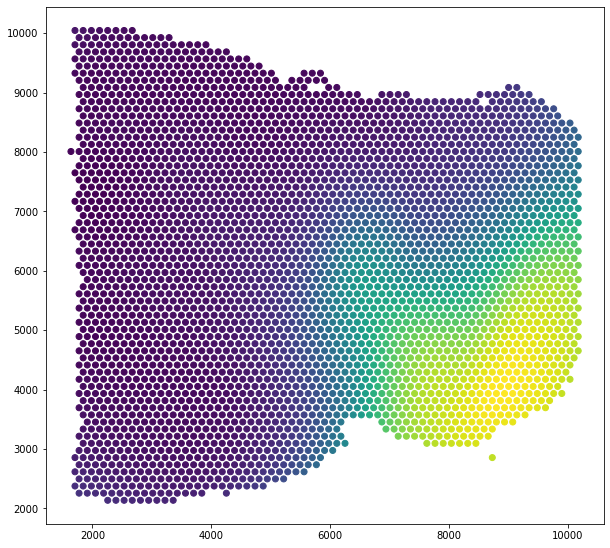

In [58]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(crd_1[:,0],crd_1[:,1], c = ref.adata.obs_vector("sample_0"))
ax.set_aspect("equal")
plt.show()

In [686]:
TRI_DIR = "/home/alma/w-projects/ccf/data/ludlar-triangle/curated"
pths = os.listdir(TRI_DIR)
adatas = [ad.read_h5ad(osp.join(TRI_DIR,p)) for p in pths]

In [687]:
for adata in adatas:
    sc.pp.normalize_per_cell(adata,1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata,n_neighbors=10)
    sc.tl.umap(adata)
    sq.gr.spatial_neighbors(adata,
                            n_neigh=6,
                            coord_type="visium",
                            )

In [693]:
for adata in adatas:
    pp.find_landmark_candidates(adata,neighbor_fraction_threshold=0.5)

In [694]:
pp.match_landmarks(adatas,max_landmarks=10)

[[0.42220587 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.3780794  0.9498246 ]
 [0.         0.         0.18361872 ... 0.         0.48360217 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.1033335  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.12956436 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.08327296 0.         ... 0.         0.20332165 0.        ]
 [0.         0.         0.         ... 0.         0.18877411 0.07112081]
 [0.         0.16559295 0.         ... 0.         0.73953414 0.        ]]
[[0.         0.         0.         ... 0.         0.64518464 0.        ]
 [0.         0.         0.         ... 

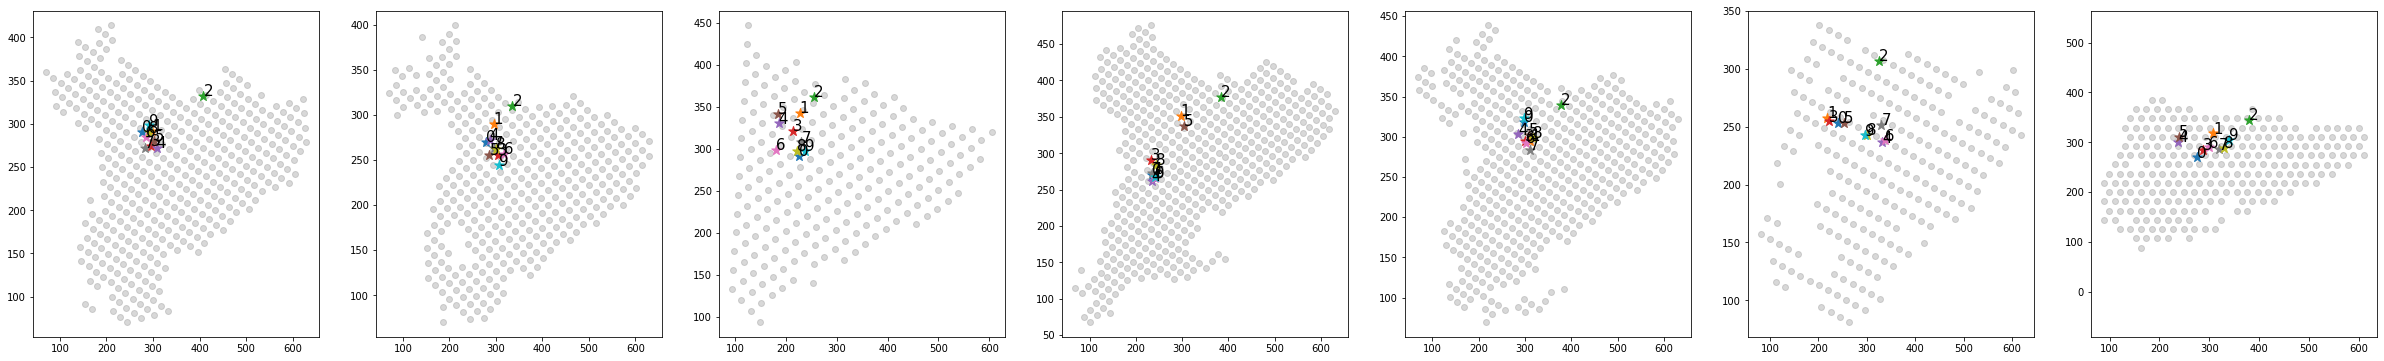

In [696]:
fig,ax = plt.subplots(1,7,figsize = (21*2,3*2))

for k,adata in enumerate(adatas):
    ax1 = ax[k]
    crd = adata.obsm["spatial"]
    ax1.scatter(crd[:,0],crd[:,1], c = "gray",alpha = 0.3)
    n_landmarks = adata.uns["curated_landmarks"].shape[0]

    lmrk = adata.uns["curated_landmarks"]

    for ii in range(n_landmarks):
        ax1.scatter(lmrk[ii,0],lmrk[ii,1],marker = "*",s=100)
        ax1.text(lmrk[ii,0],lmrk[ii,1],s = str(ii),fontsize=15)


plt.axis("equal")
plt.show()
#plt.scatter(landmarks[:,0],landmarks[:,1],s = 10,marker = "+")
